In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *


module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [25]:
NPOINTS = 13
MULT_UB = 3
MULT_LB = 1

In [2]:
lockdown_matrix_str = \
"""6.25	2	0.05	0.05	0	0	0	0.02
1.70	4	0.05	0.05	0	0	0	0.04
0.09	0.11	2	0.05	0	0	0	0.36
0.07	0.08	0.04	4.5	0	0	0	0.04
0.00	0.00	0.00	0.00	0.5	0.075	0.15	0.78
0.00	0.00	0.00	0.00	0.14	0.9	0.1	0.78
0.00	0.00	0.00	0.00	0.11	0.04	0.9	0.78
0.002	0.005	0.021	0.003	0.045	0.024	0.060	3.5"""

lockdown_matrix = np.array([[float(entry) for entry in line.split('\t')] for line in lockdown_matrix_str.split('\n')])

In [3]:
lhs_output_sim_files = []
for i in range(2000):
    fname = '/home/jmc678/covid_data/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)

scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)
centre = get_centre_point()


In [26]:
def run_multigroup_sim(sim, T):
    lockdown_statuses, sim_df = sim.run_new_trajectory(12*7)
    popsize = sim.get_total_population()
    infection_counts = sim_df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list, lockdown_statuses, list(infection_counts)

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    lockdown_trajectories = []
    infection_trajectories = []
    for _ in range(n):
        inf, hosp, lockdowns, infections = run_multigroup_sim(sim, T)
        inf_matrix.append(inf)
        hosp_matrix.append(hosp)
        lockdown_trajectories.append(lockdowns)
        infection_trajectories.append(infections)
    return inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories

def evaluate_testing_policy_v2(params_list, interaction_matrix, group_names, test_frac, T, n,
                           post_lockdown_matrix, new_cases_threshold, new_cases_time_window):
    assert len(params_list) == len(test_frac)
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    sim.configure_lockdown(post_lockdown_matrix, [True] * 7 + [False], new_cases_threshold, new_cases_time_window)
    
    inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories = run_multiple_trajectories(sim, T, n)
    
    return lockdown_trajectories, infection_trajectories

def simulate_lockdown_v2(params, infections_thresh, infections_window, nreps=10):
    simulation_population = 90890
    new_cases_thresh = infections_thresh
#     new_cases_thresh = infections_thresh / simulation_population
    test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    
    processed_params, _ = uncertainty_point_to_params_dict(params)
    
    params_dict = processed_params[0]
    interaction_matrix = processed_params[1]
    group_names = processed_params[2]
    
    return evaluate_testing_policy_v2(params_dict,
                                      interaction_matrix,
                                      group_names,
                                      test_policy,
                                      112,
                                      nreps,
                                      lockdown_matrix,
                                       new_cases_thresh,
                                       infections_window)

In [11]:
params_dict, _ = uncertainty_point_to_params_dict(centre)

In [13]:
params_dict, _ = uncertainty_point_to_params_dict(centre)
total_popsize = 0
for subparams in params_dict[0]:
    total_popsize += subparams['population_size']
print(total_popsize)

90890


In [27]:
import multiprocessing, time

def run_sim_wrapper(params, infections_thresh, infections_window,
                    proc_key, nreps, random_seed, return_dict):
    np.random.seed(random_seed)
    lockdowns, final_infections = simulate_lockdown_v2(params, 
                                                    infections_thresh, 
                                                    infections_window,
                                                    nreps=nreps)
    return_dict[proc_key] = {'lockdown_pct': lockdowns,
                            'final_infection_pct': final_infections}
    

BASE_SEED = 1000000
    
def simulate_protocol_multiprocessing(infections_thresh, infections_window, nreps):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    jobs = []
    
    base_seed = np.random.randint(1000000, 10000000)

    params_list = get_points_on_line(centre, res_pessimistic, npoints=NPOINTS, mult_lb=MULT_LB, mult_ub=MULT_UB)
    for idx, params in enumerate(params_list):
        print(idx+base_seed)
        p = multiprocessing.Process(target = run_sim_wrapper,
                                   args = (params, infections_thresh, infections_window, idx, nreps, 
                                           idx + base_seed, return_dict))
        jobs.append(p)
        p.start()

    for p in jobs:
        p.join()
    
    return return_dict


In [28]:
nreps = 50
return_dicts = {}
infection_thresholds = [150,200,250,300,350]
infection_windows = [7]


import itertools

for thresh, window in itertools.product(infection_thresholds, infection_windows):
    start = time.time()
    return_dict = simulate_protocol_multiprocessing(thresh, window, nreps)
    end = time.time()
    return_dicts[(thresh, window)] = {key:val for key,val in return_dict.items()}
    print("done simulating {} in {:.2f} seconds".format((thresh, window), end-start))


3136881
3136882
3136883
3136884
3136885
3136886
3136887
3136888
3136889
3136890
3136891
3136892
3136893
done simulating (150, 7) in 1033.08 seconds
7507483
7507484
7507485
7507486
7507487
7507488
7507489
7507490
7507491
7507492
7507493
7507494
7507495
done simulating (200, 7) in 1014.62 seconds
3737814
3737815
3737816
3737817
3737818
3737819
3737820
3737821
3737822
3737823
3737824
3737825
3737826
done simulating (250, 7) in 1025.43 seconds
4370995
4370996
4370997
4370998
4370999
4371000
4371001
4371002
4371003
4371004
4371005
4371006
4371007
done simulating (300, 7) in 1029.49 seconds
9848380
9848381
9848382
9848383
9848384
9848385
9848386
9848387
9848388
9848389
9848390
9848391
9848392
done simulating (350, 7) in 1026.91 seconds


In [15]:
sorted(return_dict.keys()


dict_keys([11, 9, 10, 2, 3, 8, 1, 7, 12, 0, 6, 4, 5])

In [16]:
return_dicts.keys()

dict_keys([(150, 7), (200, 7), (250, 7), (300, 7), (350, 7)])

In [17]:
np.linspace(0,1.5,13)

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  ])

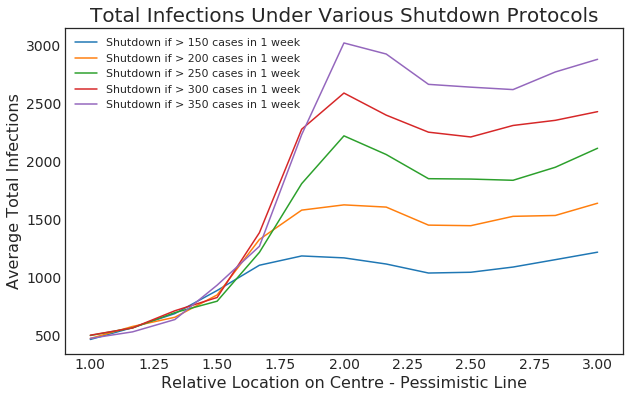

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_utils import configure_plot
configure_plot(plt)

plt.figure(figsize=(10,6))

centre_pess_indices = list(range(NPOINTS))
centre_pess_mults = np.linspace(MULT_LB,MULT_UB,NPOINTS)

keys = list(return_dicts.keys())

xlabel_mults = centre_pess_mults

for key in keys:
    if key[0] == 400:
        continue
    return_dict = return_dicts[key]
    infections = []
    for mult in centre_pess_indices:
        infections.append(np.mean([inf[-1] / 100 * total_popsize for inf in return_dict[mult]['final_infection_pct']]))
    plt.plot(xlabel_mults, infections, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Relative Location on Centre - Pessimistic Line")
plt.ylabel("Average Total Infections")
plt.title("Total Infections Under Various Shutdown Protocols")
plt.legend(loc='best', fontsize=11)

#plt.savefig('res_inst_paper_graphs/mar_19_graphs/shutdown_infections.png', dpi=450)

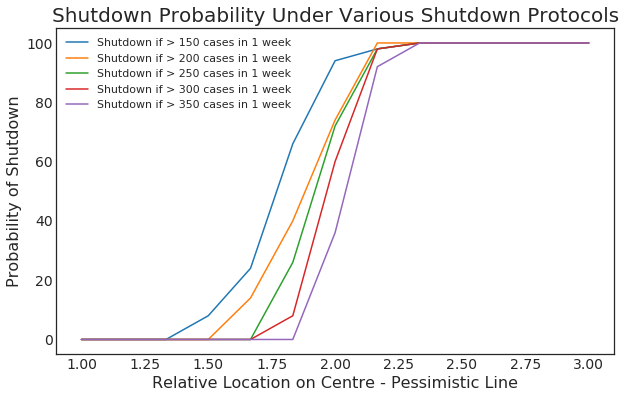

In [38]:
plt.figure(figsize=(10,6))
for key in keys:
    if key[0] == 400: 
        continue
    return_dict = return_dicts[key]
    lockdowns = []
    for mult in centre_pess_indices:
        lockdowns.append(np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) * 100)
    plt.plot(xlabel_mults, lockdowns, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Relative Location on Centre - Pessimistic Line")
plt.ylabel("Probability of Shutdown")
plt.title("Shutdown Probability Under Various Shutdown Protocols")
plt.legend(loc='best', fontsize=11)
